In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
data = pd.read_csv('dataset/in_and_out.csv', encoding='cp949')
data

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,...,9939,938,3210,3,321,0,0,0,0,20250503
1,202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,...,4897,120,1996,3,267,0,0,0,0,20250503
2,202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,...,29252,5212,8018,10,262,0,0,0,0,20250503
3,202504,1호선,시청,124,5,2267,5900,3888,28761,7841,...,3763,606,1015,0,15,0,0,0,0,20250503
4,202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,...,9416,455,3039,0,0,1,2,0,0,20250503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14857,202305,중앙선,원덕,95,0,394,6,740,182,885,...,328,3,80,0,0,0,0,0,0,20230603
14858,202305,중앙선,중랑,153,5,6886,593,10126,2329,24074,...,5311,34,486,0,0,0,0,0,0,20230603
14859,202305,중앙선,지평,0,0,0,0,4,2,384,...,0,0,0,0,0,0,0,0,0,20230603
14860,202305,중앙선,팔당,0,0,259,78,726,728,1658,...,202,0,0,0,0,0,0,0,0,20230603


In [2]:
# 5. 정준상관 벡터 시각화
from sklearn.cross_decomposition import CCA

# 1. 시간대별 승차/하차 컬럼 추출 및 정렬
승차_cols = [col for col in data.columns if '승차' in col]
하차_cols = [col for col in data.columns if '하차' in col]
승차_cols.sort()
하차_cols.sort()

# 2. 연속된 3개 시간대의 승차/하차 인원(X), 그 다음 시간대의 승차/하차 인원(Y) 생성
X_list, Y_list = [], []
for idx, row in data.iterrows():
    for i in range(len(승차_cols) - 3):
        # 입력: 연속된 3개 시간대의 승차/하차 (총 6개)
        x = []
        for j in range(3):
            x.append(row[승차_cols[i + j]])
            x.append(row[하차_cols[i + j]])
        X_list.append(x)
        # 타겟: 그 다음 시간대의 승차/하차 (2개)
        y = [row[승차_cols[i + 3]], row[하차_cols[i + 3]]]
        Y_list.append(y)

X = np.array(X_list)
Y = np.array(Y_list)

# 3. CCA 분석 (2개 정준상관 벡터)
cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X, Y)

# 4. 상관계수 출력
corr1 = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
corr2 = np.corrcoef(X_c[:, 1], Y_c[:, 1])[0, 1]
print(f'첫 번째 정준상관계수: {corr1:.3f}')
print(f'두 번째 정준상관계수: {corr2:.3f}')

첫 번째 정준상관계수: 0.907
두 번째 정준상관계수: 0.799


In [3]:
print(X)
print(Y)

[[  938  3210     3   321     0     0]
 [    3   321     0     0     0     0]
 [    0     0     0     0   650    26]
 ...
 [62911 88475 36906 64966 33050 42791]
 [36906 64966 33050 42791 37391 43840]
 [33050 42791 37391 43840 38308 48706]]
[[    0     0]
 [  650    26]
 [11355  2005]
 ...
 [37391 43840]
 [38308 48706]
 [19786 32216]]


In [4]:
from tableone import TableOne
import pandas as pd

# X, Y를 DataFrame으로 변환
X_df = pd.DataFrame(X, columns=[
    '승차1', '하차1', '승차2', '하차2', '승차3', '하차3'
])
Y_df = pd.DataFrame(Y, columns=['다음승차', '다음하차'])

# X, Y 합치기
XY_df = pd.concat([X_df, Y_df], axis=1)

# TableOne 생성
columns = X_df.columns.tolist() + Y_df.columns.tolist()
table1 = TableOne(XY_df, columns=columns, nonnormal=columns)
print(table1.tabulate(tablefmt="github"))


|                          |    | Missing   | Overall                 |
|--------------------------|----|-----------|-------------------------|
| n                        |    |           | 312102                  |
| 승차1, median [Q1,Q3]    |    | 0         | 7777.0 [605.0,19154.0]  |
| 하차1, median [Q1,Q3]    |    | 0         | 6683.0 [743.0,18459.0]  |
| 승차2, median [Q1,Q3]    |    | 0         | 8435.0 [1473.0,19829.0] |
| 하차2, median [Q1,Q3]    |    | 0         | 7595.0 [933.0,19232.8]  |
| 승차3, median [Q1,Q3]    |    | 0         | 8959.0 [2377.2,20308.8] |
| 하차3, median [Q1,Q3]    |    | 0         | 8423.0 [1857.0,19834.0] |
| 다음승차, median [Q1,Q3] |    | 0         | 9158.0 [2813.0,20435.0] |
| 다음하차, median [Q1,Q3] |    | 0         | 8888.0 [2744.2,20041.0] |


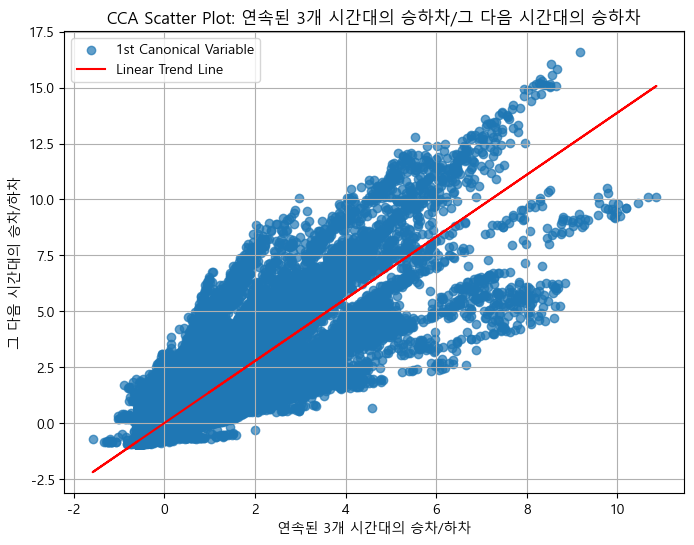

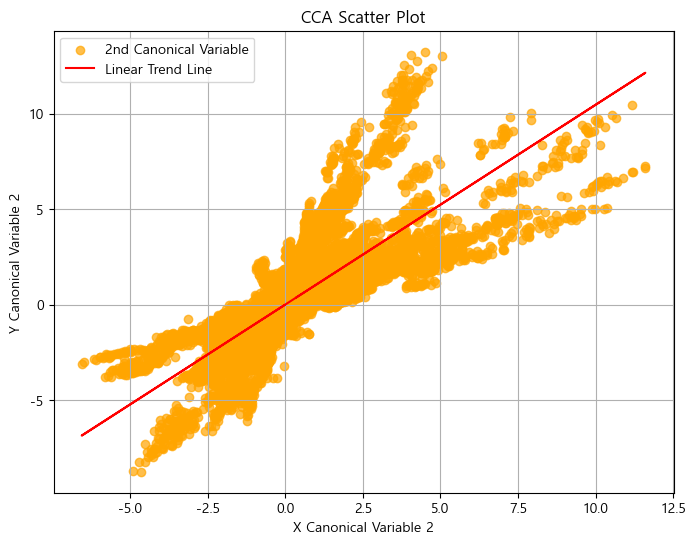

In [5]:
# 첫 번째 정준변수 산점도 및 선형 추세선
plt.figure(figsize=(8, 6))
plt.scatter(X_c[:, 0], Y_c[:, 0], alpha=0.7, label='1st Canonical Variable')
coef = np.polyfit(X_c[:, 0], Y_c[:, 0], 1)
poly1d_fn = np.poly1d(coef)
plt.plot(X_c[:, 0], poly1d_fn(X_c[:, 0]), color='red', label='Linear Trend Line')
plt.title('CCA Scatter Plot: 연속된 3개 시간대의 승하차/그 다음 시간대의 승하차')
plt.xlabel('연속된 3개 시간대의 승차/하차')
plt.ylabel('그 다음 시간대의 승차/하차')
plt.legend()
plt.grid(True)
plt.show()

# 두 번째 정준변수 산점도 및 선형 추세선
plt.figure(figsize=(8, 6))
plt.scatter(X_c[:, 1], Y_c[:, 1], alpha=0.7, color='orange', label='2nd Canonical Variable')
coef2 = np.polyfit(X_c[:, 1], Y_c[:, 1], 1)
poly1d_fn2 = np.poly1d(coef2)
plt.plot(X_c[:, 1], poly1d_fn2(X_c[:, 1]), color='red', label='Linear Trend Line')
plt.title('CCA Scatter Plot')
plt.xlabel('X Canonical Variable 2')
plt.ylabel('Y Canonical Variable 2')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

# 시간대별 승차/하차 컬럼 추출 및 정렬
승차_cols = sorted([col for col in data.columns if '승차' in col])
하차_cols = sorted([col for col in data.columns if '하차' in col])

# 연속된 3개 시간대의 승차/하차(6개)와 그 다음 시간대 승차/하차(2개) 추출
X_list, Y_list = [], []
for idx, row in data.iterrows():
    for i in range(len(승차_cols) - 3):
        x = []
        for j in range(3):
            x.append(row[승차_cols[i + j]])
            x.append(row[하차_cols[i + j]])
        y = [row[승차_cols[i + 3]], row[하차_cols[i + 3]]]
        X_list.append(x)
        Y_list.append(y)
X = np.array(X_list)
Y = np.array(Y_list)

# 각 샘플의 X, Y를 평균값으로 요약
X_mean = X.mean(axis=1)
Y_mean = Y.mean(axis=1)

# 피어슨 상관계수 및 p-value
pearson_corr, pearson_p = pearsonr(X_mean, Y_mean)
print(f"이전 3개 시간대 전체 평균과 다음 시간대 전체 평균 간 피어슨 상관계수: {pearson_corr:.3f}, p-value: {pearson_p:.2f}")

# 스피어만 상관계수 및 p-value
spearman_corr, spearman_p = spearmanr(X_mean, Y_mean)
print(f"이전 3개 시간대 전체 평균과 다음 시간대 전체 평균 간 스피어만 상관계수: {spearman_corr:.3f}, p-value: {spearman_p:.2f}")


이전 3개 시간대 전체 평균과 다음 시간대 전체 평균 간 피어슨 상관계수: 0.792, p-value: 0.00
이전 3개 시간대 전체 평균과 다음 시간대 전체 평균 간 스피어만 상관계수: 0.856, p-value: 0.00


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from tableone import TableOne

# 시간대별 승차/하차 컬럼 추출 및 정렬
승차_cols = sorted([col for col in data.columns if '승차' in col])
하차_cols = sorted([col for col in data.columns if '하차' in col])

# 연속된 3개 시간대의 승차/하차(6개)와 그 다음 시간대 승차/하차(2개) 추출
X_list, Y_list = [], []
for idx, row in data.iterrows():
    for i in range(len(승차_cols) - 3):
        x = []
        for j in range(3):
            x.append(row[승차_cols[i + j]])
            x.append(row[하차_cols[i + j]])
        y = [row[승차_cols[i + 3]], row[하차_cols[i + 3]]]
        X_list.append(x)
        Y_list.append(y)
X = np.array(X_list)
Y = np.array(Y_list)

# 가장 먼, 중간, 제일 가까운 시간대별 승차/하차 분리
far_time = X[:, 0:2]    # 가장 먼 시간대 승차, 하차
mid_time = X[:, 2:4]    # 중간 시간대 승차, 하차
close_time = X[:, 4:6]  # 제일 가까운 시간대 승차, 하차
next_time = Y           # [다음승차, 다음하차]

# TableOne 기술통계 요약
columns = ['far_승차', 'far_하차', 'mid_승차', 'mid_하차', 'close_승차', 'close_하차', '다음승차', '다음하차']
table_df = pd.DataFrame(
    np.hstack([far_time, mid_time, close_time, next_time]),
    columns=columns
)
table1 = TableOne(table_df, columns=columns, nonnormal=columns)
print(table1.tabulate(tablefmt="github"))

# 상관계수 계산 함수
def calc_corr(x, y):
    pearson_corrs, pearson_ps = [], []
    spearman_corrs, spearman_ps = [], []
    for i in range(x.shape[1]):
        pc, pp = pearsonr(x[:, i], y[:, i])
        sc, sp = spearmanr(x[:, i], y[:, i])
        pearson_corrs.append(pc)
        pearson_ps.append(pp)
        spearman_corrs.append(sc)
        spearman_ps.append(sp)
    return pearson_corrs, pearson_ps, spearman_corrs, spearman_ps

# 각 시간대별로 승차/하차와 다음 시간대 승차/하차의 상관계수 계산
labels = ['가장 먼', '중간', '제일 가까운']
all_corrs = []
for arr, label in zip([far_time, mid_time, close_time], labels):
    pearson_corrs, pearson_ps, spearman_corrs, spearman_ps = calc_corr(arr, next_time)
    for i, direction in enumerate(['승차', '하차']):
        all_corrs.append({
            '시간대': label,
            '변수': direction,
            '피어슨 상관계수': pearson_corrs[i],
            '피어슨 p-value': pearson_ps[i],
            '스피어만 상관계수': spearman_corrs[i],
            '스피어만 p-value': spearman_ps[i]
        })

corr_df = pd.DataFrame(all_corrs)
print(corr_df)


|                            |    | Missing   | Overall                 |
|----------------------------|----|-----------|-------------------------|
| n                          |    |           | 312102                  |
| far_승차, median [Q1,Q3]   |    | 0         | 7777.0 [605.0,19154.0]  |
| far_하차, median [Q1,Q3]   |    | 0         | 6683.0 [743.0,18459.0]  |
| mid_승차, median [Q1,Q3]   |    | 0         | 8435.0 [1473.0,19829.0] |
| mid_하차, median [Q1,Q3]   |    | 0         | 7595.0 [933.0,19232.8]  |
| close_승차, median [Q1,Q3] |    | 0         | 8959.0 [2377.2,20308.8] |
| close_하차, median [Q1,Q3] |    | 0         | 8423.0 [1857.0,19834.0] |
| 다음승차, median [Q1,Q3]   |    | 0         | 9158.0 [2813.0,20435.0] |
| 다음하차, median [Q1,Q3]   |    | 0         | 8888.0 [2744.2,20041.0] |
      시간대  변수  피어슨 상관계수  피어슨 p-value  스피어만 상관계수  스피어만 p-value
0    가장 먼  승차  0.603789          0.0   0.668837           0.0
1    가장 먼  하차  0.529004          0.0   0.710447           0.0
2      중간  승차  0.719